In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload

In [3]:
%load_ext line_profiler

In [4]:
%autoreload 2

In [1330]:
import math
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import pickle

In [6]:
import statsmodels.api as sm

In [9]:
from datahandling import DataHandler
from preprocessing import Preprocessor, Standardizer

## Importing data

In [10]:
raw_df = DataHandler().read()

## Checking for discontinuities of bad range in data

In [12]:
for (Id, date), daily_data in raw_df.groupby(["Id", pd.Grouper(level=0, freq='1D')]):
    d = daily_data
    if d.index[0].time() != dt.time(9, 45):
        print(f"id {Id} has starts late ({d.index[0].time()}) on day {date}")
        break
    if d.index[-1].time() != dt.time(16, 0):
         print(f"id {Id} has ends early ({d.index[-1].time()}) on day {date}")
            
    if (d.index != pd.date_range(start=d.index[0], end=d.index[-1], freq='15T', inclusive="both")).any():
        print(f"id {Id} has discontinuous data on day {date}")
        break
        
print("No bad data found")

No bad data found


In [ ]:
# => we can use index values as there is no discontinuities

## Checking matching data between daily and intraday

In [24]:
last_data = raw_df.groupby(["Id", pd.Grouper(level=0, freq="D")]).last()

In [31]:
last_data

CumReturnResid  CumReturnRaw  CumVolume  \
Id                                                                           
BBG000B9WH86           2010-01-04       -0.000919      0.032249   25160630   
                       2010-01-05       -0.037940     -0.031241   48945660   
                       2010-01-06        0.021264      0.050234   44739384   
                       2010-01-07       -0.018720     -0.020077   37071020   
                       2010-01-08       -0.002510      0.024103   32271728   
...                                           ...           ...        ...   
GEN_EQ0140919900001000 2011-01-12        0.004308      0.005457    1978935   
                       2011-01-13        0.007952      0.006559    1865174   
                       2011-01-14        0.002274      0.005392    1396973   
                       2011-01-18        0.003268      0.005363    1430620   
                       2011-01-19       -0.000118     -0.001779    1358290   

                                  SYMBOL   MIC  FREE_FLOAT_PERCENTAGE  \
Id                                                                      
BBG000B9WH86           2010-01-04     AA  XNYS                99.7169   
                       2010-01-05     AA  XNYS                99.7170   
                       2010-01-06     AA  XNYS                99.7170   
                       2010-01-07     AA  XNYS                99.7170   
                       2010-01-08     AA  XNYS                99.7170   
...                                  ...   ...                    ...   
GEN_EQ0140919900001000 2011-01-12    PGN  XNYS                99.7662   
                       2011-01-13    PGN  XNYS                99.7662   
                       2011-01-14    PGN  XNYS                99.7662   
                       2011-01-18    PGN  XNYS                99.7662   
                       2011-01-19    PGN  XNYS                99.7662   

                                   EST_VOL       MDV_63   Open    High    Low  \
Id                                                                              
BBG000B9WH86           2010-01-04  0.17017  392090530.0  16.47  16.890  16.40   
                       2010-01-05  0.18214  392090530.0  16.83  16.850  16.03   
                       2010-01-06  0.18960  392090530.0  16.31  17.060  16.26   
                       2010-01-07  0.19430  392090530.0  16.52  16.660  16.30   
                       2010-01-08  0.20632  392090530.0  16.46  17.020  16.45   
...                                    ...          ...    ...     ...    ...   
GEN_EQ0140919900001000 2011-01-12  0.07674   63214480.0  43.94  44.275  43.93   
                       2011-01-13  0.07198   63598716.0  44.20  44.550  44.20   
                       2011-01-14  0.07388   63598716.0  44.41  44.830  44.26   
                       2011-01-18  0.06739   63598716.0  44.74  45.000  44.64   
                       2011-01-19  0.07528   63598716.0  44.95  45.050  44.85   

                                   Close      Volume  PxAdjFactor  \
Id                                                                  
BBG000B9WH86           2010-01-04  16.65  25872368.0     1.059996   
                       2010-01-05  16.13  49862200.0     1.059996   
                       2010-01-06  16.97  46703668.0     1.059996   
                       2010-01-07  16.61  38641508.0     1.059996   
                       2010-01-08  17.02  33081926.0     1.059996   
...                                  ...         ...          ...   
GEN_EQ0140919900001000 2011-01-12  44.24   2064663.0     1.218775   
                       2011-01-13  44.52   1962341.0     1.218775   
                       2011-01-14  44.73   1543797.0     1.218775   
                       2011-01-18  44.96   1534524.0     1.218775   
                       2011-01-19  44.90   1499454.0     1.218775   

                                   SharesAdjFactor  DailyReturn  
Id                                                  

In [52]:
last_data["DailyReturn"] =  (last_data["Close"] * last_data["PxAdjFactor"]).groupby("Id").pct_change()


In [56]:
last_data["ReturnError"] = ((last_data["CumReturnRaw"] - last_data["DailyReturn"]).abs() / last_data["DailyReturn"].abs()).clip(-1, 1)


In [57]:
last_data["VolumeError"] = ((last_data["CumVolume"] - last_data["Volume"]).abs() / last_data["Volume"]).clip(-1, 1)

array([[<Axes: title={'center': 'ReturnError'}>,
        <Axes: title={'center': 'VolumeError'}>]], dtype=object)

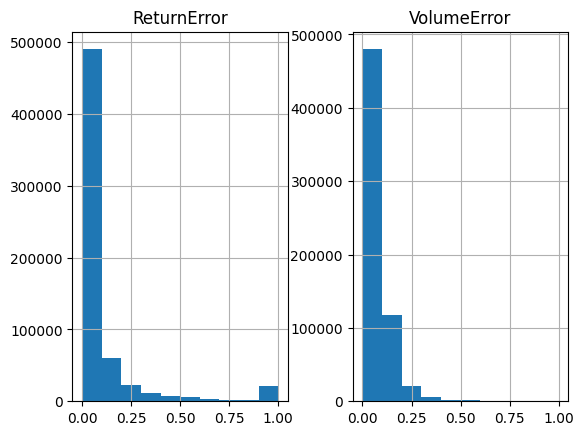

In [58]:
last_data[["ReturnError", "VolumeError"]].hist()

array([[<Axes: title={'center': 'ReturnError'}>,
        <Axes: title={'center': 'VolumeError'}>]], dtype=object)

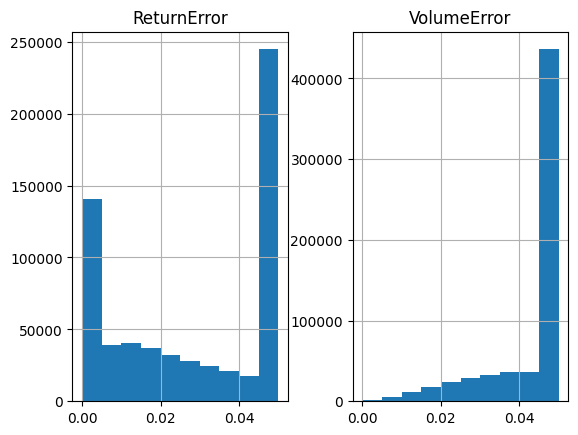

In [61]:
last_data[["ReturnError", "VolumeError"]].clip(0, 0.05).hist()

## Checking Turnover

In [89]:
daily_ids = raw_df.groupby(pd.Grouper(level=0, freq="D"))["Id"].unique().to_frame()
daily_ids = daily_ids[daily_ids.apply(lambda x: x.values[0].shape[0], axis=1)>0]
daily_ids["TomorrowsID"] = daily_ids.shift(-1)
daily_ids.drop(daily_ids.tail(1).index, inplace=True)
daily_ids

Id  \
2010-01-04  [BBG000MQ1SN9, BBG000BBCQD7, BBG000BBB3K1, BBG...   
2010-01-05  [BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG...   
2010-01-06  [BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG...   
2010-01-07  [BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG...   
2010-01-08  [BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG...   
...                                                       ...   
2014-12-23  [BBG000R8ZVD1, BBG000BGFZR8, BBG000BF3NZ1, BBG...   
2014-12-24  [BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG...   
2014-12-26  [BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG...   
2014-12-29  [BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG...   
2014-12-30  [BBG000BQD1J2, BBG000BQG2C4, BBG000BFVXX0, BBG...   

                                                  TomorrowsID  
2010-01-04  [BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG...  
2010-01-05  [BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG...  
2010-01-06  [BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG...  
2010-01-07  [BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG...  
2010-01-08  [BBG000BJNGN9, BBG000BR1W32, BBG000BBB3K1, BBG...  
...                                                       ...  
2014-12-23  [BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG...  
2014-12-24  [BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG...  
2014-12-26  [BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG...  
2014-12-29  [BBG000BQD1J2, BBG000BQG2C4, BBG000BFVXX0, BBG...  
2014-12-30  [BBG000G8N9C6, BBG000BQD1J2, BBG000BNPSQ9, BBG...  

[1257 rows x 2 columns]

In [92]:
compute_changes = lambda row: np.concatenate([np.setdiff1d(row["Id"], row["TomorrowsID"]), np.setdiff1d(row["TomorrowsID"],row["Id"])])

In [93]:
daily_ids["Changes"] = daily_ids.apply(compute_changes, axis=1)
daily_ids["Turnover"] = daily_ids["Changes"].apply(len)/daily_ids["Id"].apply(len)
daily_ids

Id  \
2010-01-04  [BBG000MQ1SN9, BBG000BBCQD7, BBG000BBB3K1, BBG...   
2010-01-05  [BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG...   
2010-01-06  [BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG...   
2010-01-07  [BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG...   
2010-01-08  [BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG...   
...                                                       ...   
2014-12-23  [BBG000R8ZVD1, BBG000BGFZR8, BBG000BF3NZ1, BBG...   
2014-12-24  [BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG...   
2014-12-26  [BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG...   
2014-12-29  [BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG...   
2014-12-30  [BBG000BQD1J2, BBG000BQG2C4, BBG000BFVXX0, BBG...   

                                                  TomorrowsID  \
2010-01-04  [BBG000MQ1SN9, BBG000BBB3K1, BBG000BNMHS4, BBG...   
2010-01-05  [BBG000BJNGN9, BBG000CPHYL4, BBG000MQ1SN9, BBG...   
2010-01-06  [BBG000BJNGN9, BBG000BBCQD7, BBG000MQ1SN9, BBG...   
2010-01-07  [BBG000C04224, BBG000BC9938, BBG000BBCQD7, BBG...   
2010-01-08  [BBG000BJNGN9, BBG000BR1W32, BBG000BBB3K1, BBG...   
...                                                       ...   
2014-12-23  [BBG000BQG2C4, BBG000R8ZVD1, BBG000BGFZR8, BBG...   
2014-12-24  [BBG000BFVXX0, BBG000BQG2C4, BBG000R8ZVD1, BBG...   
2014-12-26  [BBG000BB38Q3, BBG000BQG2C4, BBG000BFVXX0, BBG...   
2014-12-29  [BBG000BQD1J2, BBG000BQG2C4, BBG000BFVXX0, BBG...   
2014-12-30  [BBG000G8N9C6, BBG000BQD1J2, BBG000BNPSQ9, BBG...   

                                                      Changes  Turnover  
2010-01-04             [BBG000BBCQD7, GEN_EQ0010168800001000]     0.004  
2010-01-05  [BBG000BBB3K1, GEN_EQ0010168800001000, BBG000B...     0.008  
2010-01-06  [BBG000C23PB0, BBG000JF5CV9, BBG000BBB3K1, BBG...     0.008  
2010-01-07  [BBG000BJNGN9, BBG000BNMHS4, BBG000BC9938, BBG...     0.008  
2010-01-08  [BBG000BC9938, BBG000C04224, BBG000CPHYL4, BBG...     0.012  
...                                                       ...       ...  
2014-12-23                       [BBG000BR37X2, BBG000BQG2C4]     0.004  
2014-12-24                       [BBG000BVN235, BBG000BFVXX0]     0.004  
2014-12-26                       [BBG000BGFZR8, BBG000BB38Q3]     0.004  
2014-12-29                       [BBG000BB38Q3, BBG000BQD1J2]     0.004  
2014-12-30  [BBG000BV3SC0, BBG000C11MQ5, BBG000BNPSQ9, BBG...     0.008  

[1257 rows x 4 columns]

<Axes: >

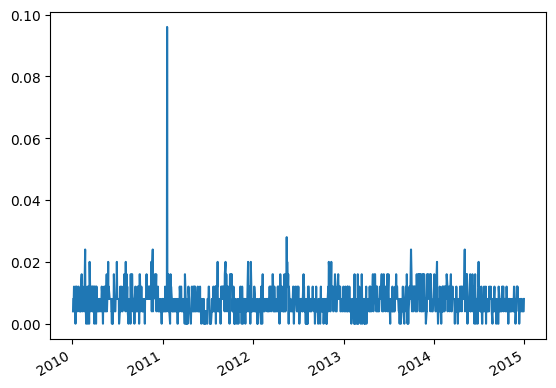

In [94]:
daily_ids["Turnover"].plot()


## Checking Preprocessor

In [95]:
raw_df

Id  CumReturnResid  CumReturnRaw  CumVolume  \
2010-01-04 09:45:00  BBG000MQ1SN9        0.002070      0.012778      43347   
2010-01-04 09:45:00  BBG000BBCQD7       -0.012105      0.007787     229661   
2010-01-04 09:45:00  BBG000BBB3K1       -0.001020      0.001321      62697   
2010-01-04 09:45:00  BBG000BNMHS4        0.012179      0.025810      47650   
2010-01-04 09:45:00  BBG000C23PB0        0.003520      0.008454     239259   
...                           ...             ...           ...        ...   
2014-12-31 16:00:00  BBG000BPH459       -0.003270     -0.011909   16810020   
2014-12-31 16:00:00  BBG000GZQ728       -0.000065     -0.006342    9221446   
2014-12-31 16:00:00  BBG000CKGBP2       -0.008449     -0.010234   11508879   
2014-12-31 16:00:00  BBG000MM2P62       -0.005813     -0.015146   18519636   
2014-12-31 16:00:00  BBG000B9XRY4       -0.009474     -0.018974   37043464   

                    SYMBOL   MIC  FREE_FLOAT_PERCENTAGE  EST_VOL  \
2010-01-04 09:45:00    DVA  XNYS                99.6464  0.13074   
2010-01-04 09:45:00    SLM  XNYS                99.1117  0.31610   
2010-01-04 09:45:00    RAI  XNYS                57.7643  0.11253   
2010-01-04 09:45:00    MAN  XNYS                99.3401  0.18568   
2010-01-04 09:45:00    SAI  XNYS                99.1347  0.11252   
...                    ...   ...                    ...      ...   
2014-12-31 16:00:00   MSFT  XNGS                91.5633  0.12146   
2014-12-31 16:00:00    XOM  XNYS                99.7689  0.09480   
2014-12-31 16:00:00   GILD  XNGS                99.4121  0.20535   
2014-12-31 16:00:00     FB  XNGS                95.9988  0.17343   
2014-12-31 16:00:00   AAPL  XNGS                99.9441  0.16047   

                           MDV_63    Open    High     Low   Close      Volume  \
2010-01-04 09:45:00  4.383275e+07   59.12   60.05   59.09   59.92    955120.0   
2010-01-04 09:45:00  4.409296e+07   11.45   11.72   11.32   11.54   2566745.0   
2010-01-04 09:45:00  7.588626e+07   53.33   53.52   53.00   53.24    812905.0   
2010-01-04 09:45:00  4.413393e+07   54.94   56.58   54.78   56.41   1108030.0   
2010-01-04 09:45:00  4.440541e+07   19.02   19.17   18.89   19.11   3500468.0   
...                           ...     ...     ...     ...     ...         ...   
2014-12-31 16:00:00  1.383197e+09   46.73   47.44   46.45   46.45  21551092.0   
2014-12-31 16:00:00  1.273231e+09   92.42   93.13   92.06   92.45  11326179.0   
2014-12-31 16:00:00  1.589295e+09   96.00   96.75   94.24   94.26  13851283.0   
2014-12-31 16:00:00  2.258944e+09   79.54   79.80   77.86   78.02  20004654.0   
2014-12-31 16:00:00  5.093251e+09  112.82  113.13  110.21  110.38  41304130.0   

                     PxAdjFactor  SharesAdjFactor  
2010-01-04 09:45:00     1.000000         1.000000  
2010-01-04 09:45:00     1.000000         1.000000  
2010-01-04 09:45:00     1.160364         1.000000  
2010-01-04 09:45:00     1.034430         1.000000  
2010-01-04 09:45:00     1.000000         1.000000  
...                          ...              ...  
2014-12-31 16:00:00     1.188881         1.000000  
2014-12-31 16:00:00     1.188282         1.000000  
2014-12-31 16:00:00     2.000000         0.500000  
2014-12-31 16:00:00     1.000000         1.000000  
2014-12-31 16:00:00     7.391928         0.142857  

[16354000 rows x 16 columns]

In [ ]:
day_sep = raw_df[["Id", "CumReturnResid"]].groupby(["Id", raw_df.index.date, raw_df.index.time>dt.time(15,30)]).last()
day_sep

In [ ]:
day_sep.xs("BBG000B9WH86", level=0)

In [ ]:
R1530_1600 = (-0.000919 +1) / (-0.002424+1) - 1
R1530_1600

In [ ]:
(R1530_1600 + 1) * (-0.039352 + 1) - 1

In [ ]:
adj_end = day_sep.add(1).groupby(level=[0, 1]).pct_change().dropna().droplevel(2)
adj_end

In [ ]:
begin = day_sep.xs(False, level=2).shift(-1)
begin

In [ ]:
target = adj_end.merge(begin, how="inner", left_index=True, right_index=True).stack().add(1).groupby(level=[0, 1]).prod().sub(1).rename("Target").to_frame()

In [ ]:
target

In [ ]:
target.sort_index().unstack().T.droplevel(0)

## Comparing daily vs intraday volume

In [ ]:
raw_df2 = DataHandler().read(end="2010-06-01")

In [ ]:
volume = raw_df2[["Id", "CumVolume"]].groupby(["Id", raw_df2.index.date, raw_df2.index.time>=dt.time(10,0)]).last()
volume

In [ ]:
total_intra = volume.groupby(level=[0,1]).sum()
total_intra

In [ ]:
after10_vol = volume.groupby(level=[0,1]).diff()

In [ ]:
after10_vol

In [ ]:
total_vol = raw_df2.groupby(["Id", raw_df2.index.date])["Volume"].first().astype(int).to_frame()
total_vol

In [ ]:
vol_diff = total_intra.merge(total_vol, how="outer", left_index=True, right_index=True)

In [ ]:
((vol_diff["CumVolume"] - vol_diff["Volume"]).abs() / vol_diff["Volume"]).plot()

## Checking that intraday data is correct

In [ ]:
intraday_tickdata = Preprocessor(raw_df).create_raw_intraday_features()

In [ ]:
eval_copy_tick = intraday_tickdata.copy()
eval_copy_tick["ResidReturn"] = eval_copy_tick["ResidReturn"].add(1)
grouped_tick = eval_copy_tick.groupby([pd.Grouper(level=0), pd.Grouper(freq='1D', level=1)])
agg_day_tick = pd.concat([grouped_tick["ResidReturn"].prod().sub(1), grouped_tick["Volume"].sum().astype(int)], axis=1)
agg_day_tick

In [ ]:
real_agg = raw_df2[["Id", "CumReturnResid", "CumVolume"]].groupby(["Id", raw_df2.index.date]).last()
real_agg

## Getting market weights by log

In [1346]:
market_weights = np.sqrt(raw_df.set_index("Id", append=True).groupby([pd.Grouper(level=0, freq="D"), pd.Grouper(level=1)])["MDV_63"].first())

In [1347]:
market_weights = market_weights / market_weights.groupby(level=0).transform('sum')

In [1349]:
market_weights

            Id          
2010-01-04  BBG000B9WH86    0.003256
            BBG000B9WJ73    0.001599
            BBG000B9XRY4    0.009334
            BBG000B9XYV2    0.001669
            BBG000B9YJ35    0.001167
                              ...   
2014-12-31  BBG002S5ZRF9    0.001610
            BBG002W96FT9    0.004371
            BBG0039320N9    0.001763
            BBG005P7Q881    0.003375
            BBG006B6PVN9    0.001183
Name: MDV_63, Length: 629000, dtype: float64

In [101]:
market_weights

Weight
           Id                    
2010-01-04 BBG000B9WH86  0.002124
           BBG000B9WJ73  0.001971
           BBG000B9XRY4  0.002350
           BBG000B9XYV2  0.001980
           BBG000B9YJ35  0.001904
...                           ...
2014-12-31 BBG002S5ZRF9  0.001969
           BBG002W96FT9  0.002180
           BBG0039320N9  0.001988
           BBG005P7Q881  0.002125
           BBG006B6PVN9  0.001904

[629000 rows x 1 columns]

## Checking preprocessing

In [104]:
p = Preprocessor(raw_df)

In [105]:
dataset = p.run()

In [106]:
dataset

ResidReturnD-20  ResidReturnD-19  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.018772        -0.073601   
                       2011-01-13        -0.073601        -0.090919   
                       2011-01-14        -0.090919         0.011597   
                       2011-01-18         0.011597        -0.074718   
                       2011-01-19        -0.074718        -0.016516   

                                   ResidReturnD-18  ResidReturnD-17  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.090919         0.011597   
                       2011-01-13         0.011597        -0.074718   
                       2011-01-14        -0.074718        -0.016516   
                       2011-01-18        -0.016516        -0.030521   
                       2011-01-19        -0.030521         0.010474   

                                   ResidReturnD-16  ResidReturnD-15  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.074718        -0.016516   
                       2011-01-13        -0.016516        -0.030521   
                       2011-01-14        -0.030521         0.010474   
                       2011-01-18         0.010474        -0.026305   
                       2011-01-19        -0.026305        -0.042175   

                                   ResidReturnD-14  ResidReturnD-13  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.030521         0.010474   
                       2011-01-13         0.010474        -0.026305   
                       2011-01-14        -0.026305        -0.042175   
                       2011-01-18        -0.042175         0.006086   
                       2011-01-19         0.006086         0.025064   

                                   ResidReturnD-12  ResidReturnD-11  ...  \
BBG000B9WH86           2010-01-04              NaN              NaN  ...   
                       2010-01-05              NaN              NaN  ...   
                       2010-01-06              NaN              NaN  ...   
                       2010-01-07              NaN              NaN  ...   
                       2010-01-08              NaN              NaN  ...   
...                                            ...              ...  ...   
GEN_EQ0140919900001000 2011-01-12        -0.026305        -0.042175  ...   
               

In [107]:
raw_dataset = dataset.copy()

## Time Series Analysis

In [108]:
ts = dataset["Target"]

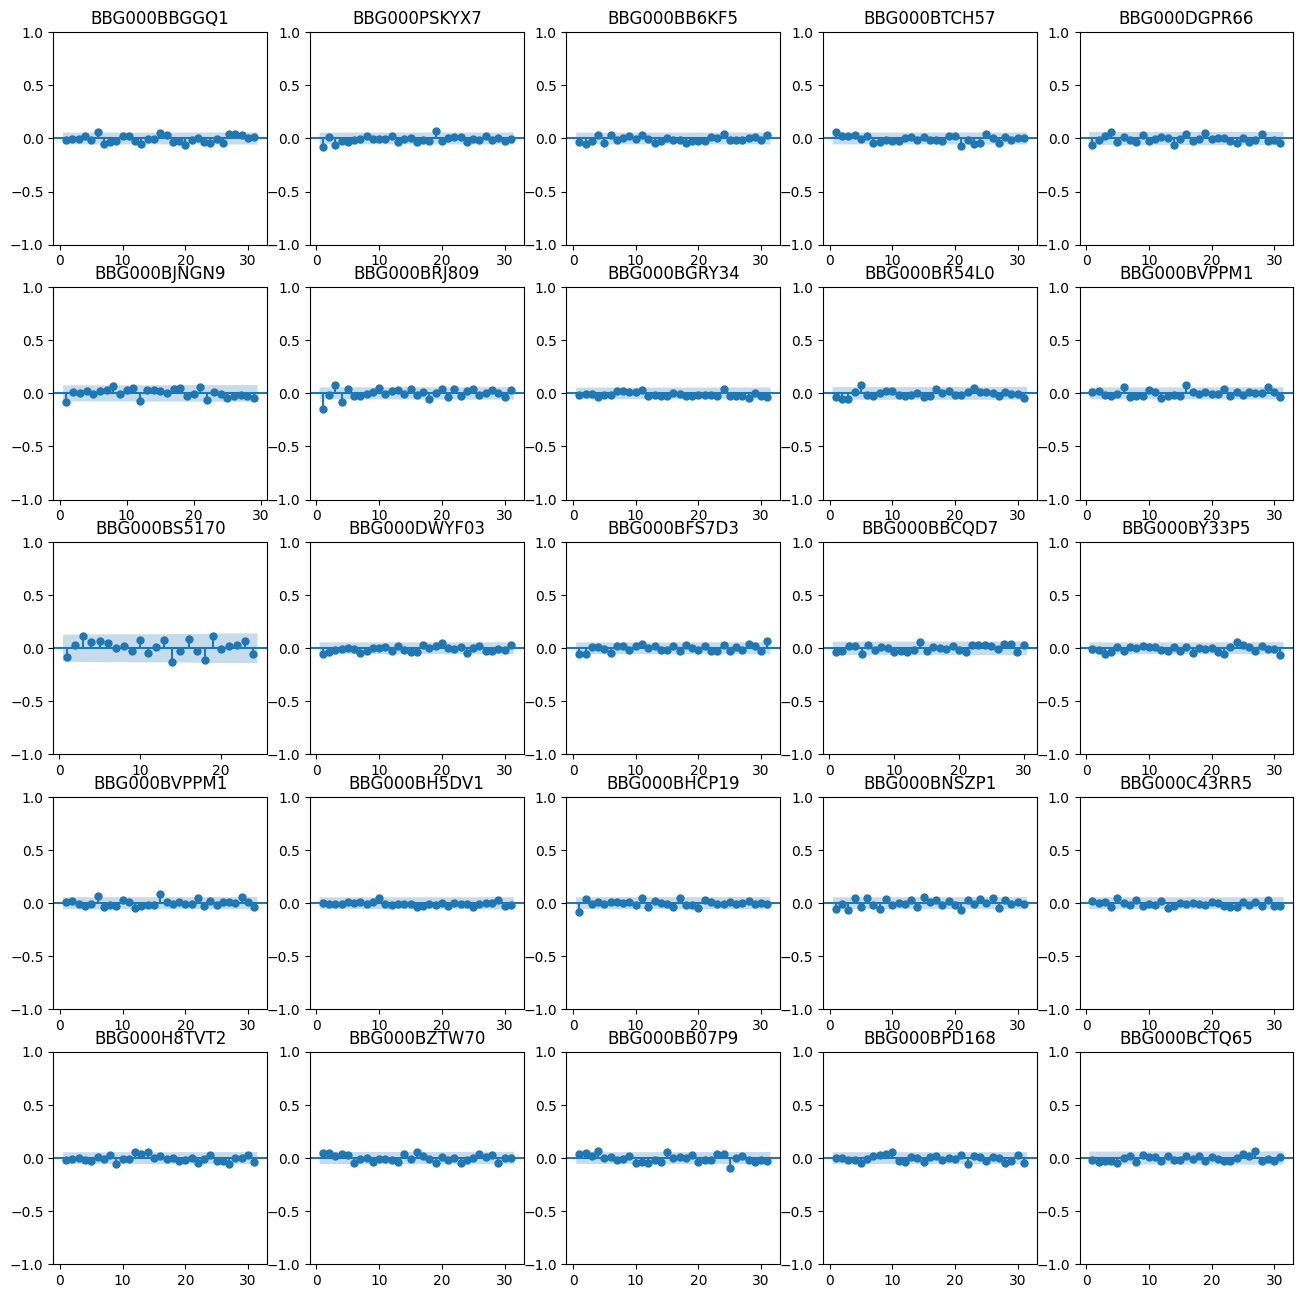

In [109]:
sample_ids = np.random.choice(ts.index.get_level_values(0), 25, replace=False)

fig, ax = plt.subplots(5, 5, figsize=(16, 16))
for i, Id in enumerate(sample_ids):
    _ = sm.graphics.tsa.plot_acf(ts.xs(Id, level=0), zero=False, ax=ax[i % 5][i // 5], title=f"{Id}")

In [110]:
monthly_corr = [(month, data.unstack(0).corr()) for month, data in ts.groupby(pd.Grouper(level=1, freq="3M"))]

KeyboardInterrupt: 

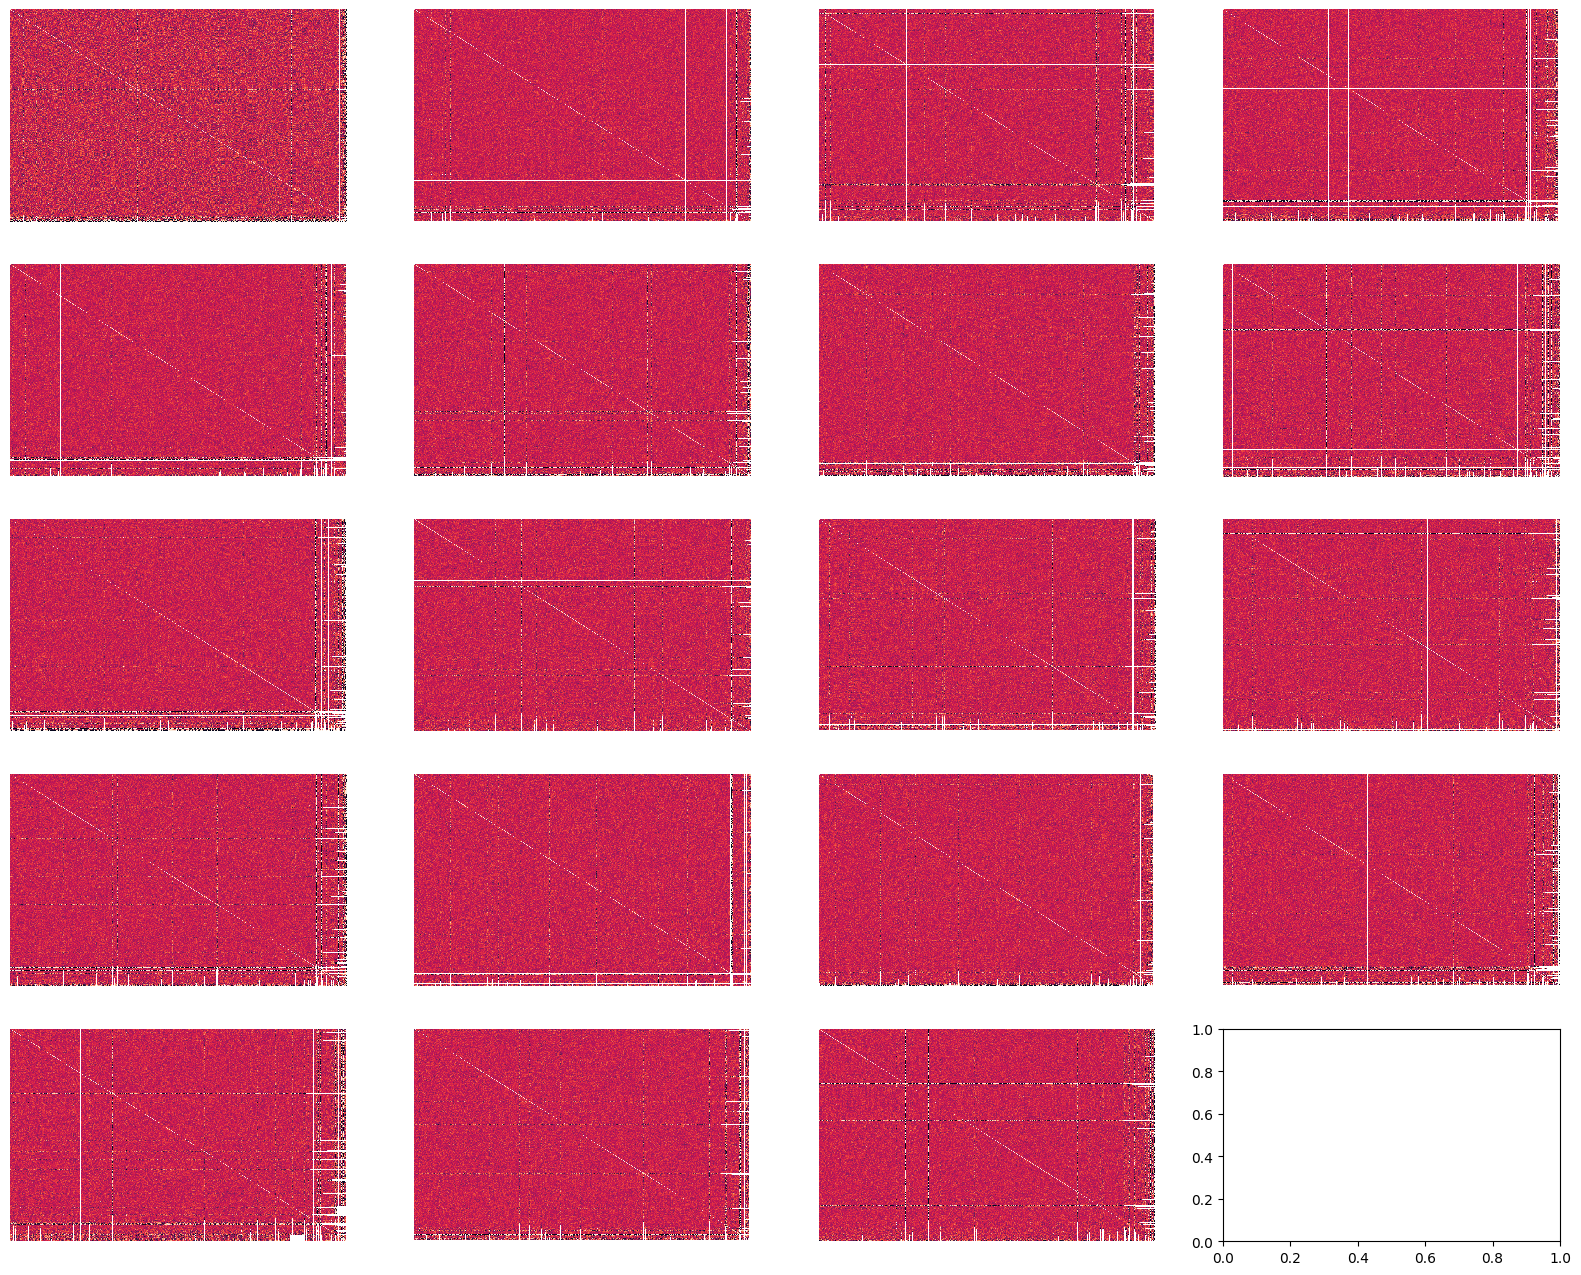

In [111]:
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
for i, (month, data) in enumerate(monthly_corr[:-1]):
    sns.heatmap(data, ax=ax[i % 5][i // 5], xticklabels=False, yticklabels=False, cbar=False)

## Train val split

In [113]:
dataset

ResidReturnD-20  ResidReturnD-19  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.018772        -0.073601   
                       2011-01-13        -0.073601        -0.090919   
                       2011-01-14        -0.090919         0.011597   
                       2011-01-18         0.011597        -0.074718   
                       2011-01-19        -0.074718        -0.016516   

                                   ResidReturnD-18  ResidReturnD-17  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.090919         0.011597   
                       2011-01-13         0.011597        -0.074718   
                       2011-01-14        -0.074718        -0.016516   
                       2011-01-18        -0.016516        -0.030521   
                       2011-01-19        -0.030521         0.010474   

                                   ResidReturnD-16  ResidReturnD-15  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.074718        -0.016516   
                       2011-01-13        -0.016516        -0.030521   
                       2011-01-14        -0.030521         0.010474   
                       2011-01-18         0.010474        -0.026305   
                       2011-01-19        -0.026305        -0.042175   

                                   ResidReturnD-14  ResidReturnD-13  \
BBG000B9WH86           2010-01-04              NaN              NaN   
                       2010-01-05              NaN              NaN   
                       2010-01-06              NaN              NaN   
                       2010-01-07              NaN              NaN   
                       2010-01-08              NaN              NaN   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.030521         0.010474   
                       2011-01-13         0.010474        -0.026305   
                       2011-01-14        -0.026305        -0.042175   
                       2011-01-18        -0.042175         0.006086   
                       2011-01-19         0.006086         0.025064   

                                   ResidReturnD-12  ResidReturnD-11  ...  \
BBG000B9WH86           2010-01-04              NaN              NaN  ...   
                       2010-01-05              NaN              NaN  ...   
                       2010-01-06              NaN              NaN  ...   
                       2010-01-07              NaN              NaN  ...   
                       2010-01-08              NaN              NaN  ...   
...                                            ...              ...  ...   
GEN_EQ0140919900001000 2011-01-12        -0.026305        -0.042175  ...   
               

In [1357]:
data_train = dataset.fillna(0).reset_index(0, names="Id").loc[:'2014-01-01'].set_index("Id", append=True).swaplevel(0,1)

In [1358]:
data_val = dataset.fillna(0).reset_index(0, names="Id").loc['2014-01-01':].set_index("Id", append=True).swaplevel(0,1)

/var/folders/9w/vls_pj350g3b62pyz_4t5hp80000gn/T/ipykernel_96170/1563575910.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data_val = dataset.fillna(0).reset_index(0, names="Id").loc['2014-01-01':].set_index("Id", append=True).swaplevel(0,1)


In [1359]:
X_train, y_train = data_train.drop("Target", axis=1), data_train['Target']

In [1360]:
X_train

ResidReturnD-20  ResidReturnD-19  \
Id                                                                    
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.018772        -0.073601   
                       2011-01-13        -0.073601        -0.090919   
                       2011-01-14        -0.090919         0.011597   
                       2011-01-18         0.011597        -0.074718   
                       2011-01-19        -0.074718        -0.016516   

                                   ResidReturnD-18  ResidReturnD-17  \
Id                                                                    
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.090919         0.011597   
                       2011-01-13         0.011597        -0.074718   
                       2011-01-14        -0.074718        -0.016516   
                       2011-01-18        -0.016516        -0.030521   
                       2011-01-19        -0.030521         0.010474   

                                   ResidReturnD-16  ResidReturnD-15  \
Id                                                                    
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.074718        -0.016516   
                       2011-01-13        -0.016516        -0.030521   
                       2011-01-14        -0.030521         0.010474   
                       2011-01-18         0.010474        -0.026305   
                       2011-01-19        -0.026305        -0.042175   

                                   ResidReturnD-14  ResidReturnD-13  \
Id                                                                    
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.030521         0.010474   
                       2011-01-13         0.010474        -0.026305   
                       2011-01-14        -0.026305        -0.042175   
                       2011-01-18        -0.042175         0.006086   
                       2011-01-19         0.006086         0.025064   

                                   ResidReturnD-12  ResidReturnD-11  ...  \
Id                                                                   ...   
BBG000B9WH86           2010-01-04         0.000000         0.000000  ...   
                       2010-01-05         0.000000         0.000000  ...   
                       2010-01-06  

In [118]:
y_train

level_0                           
BBG000B9WH86            2010-01-04   -0.161663
                        2010-01-05    0.143294
                        2010-01-06   -0.102812
                        2010-01-07   -0.044104
                        2010-01-08    0.119874
                                        ...   
GEN_EQ0140919900001000  2011-01-12    0.061040
                        2011-01-13    0.071008
                        2011-01-14    0.033858
                        2011-01-18   -0.000999
                        2011-01-19   -0.005147
Name: Target, Length: 500629, dtype: float64

In [443]:
X_val, y_val = data_val.drop("Target", axis=1), data_val['Target']

In [1351]:
train_weights = market_weights.copy().swaplevel(0,1).squeeze()
train_weights

Id                      
BBG000B9WH86  2010-01-04    0.003256
BBG000B9WJ73  2010-01-04    0.001599
BBG000B9XRY4  2010-01-04    0.009334
BBG000B9XYV2  2010-01-04    0.001669
BBG000B9YJ35  2010-01-04    0.001167
                              ...   
BBG002S5ZRF9  2014-12-31    0.001610
BBG002W96FT9  2014-12-31    0.004371
BBG0039320N9  2014-12-31    0.001763
BBG005P7Q881  2014-12-31    0.003375
BBG006B6PVN9  2014-12-31    0.001183
Name: MDV_63, Length: 629000, dtype: float64

In [1352]:
train_weights.drop(list(set(train_weights.index).difference(set(X_train.index))), inplace=True)

In [1080]:
train_weights

level_0                 
BBG000B9WH86  2010-01-04    0.002124
BBG000B9WJ73  2010-01-04    0.001971
BBG000B9XRY4  2010-01-04    0.002350
BBG000B9XYV2  2010-01-04    0.001980
BBG000B9YJ35  2010-01-04    0.001904
                              ...   
BBG002S5ZRF9  2013-12-31    0.001978
BBG0035LY913  2013-12-31    0.001926
BBG003641015  2013-12-31    0.001963
BBG0039320N9  2013-12-31    0.001967
BBG003P9ZSL3  2013-12-31    0.001946
Name: Weight, Length: 500629, dtype: float64

In [1083]:
val_weights = market_weights.copy().swaplevel(0,1).squeeze()

In [1084]:
val_weights.drop(list(set(val_weights.index).difference(set(X_val.index))), inplace=True)

In [1085]:
val_weights

Id                      
BBG000B9WH86  2014-01-02    0.002043
BBG000B9XRY4  2014-01-02    0.002385
BBG000B9ZXB4  2014-01-02    0.002053
BBG000BB03M1  2014-01-02    0.001930
BBG000BB07P9  2014-01-02    0.002067
                              ...   
BBG002S5ZRF9  2014-12-31    0.001969
BBG002W96FT9  2014-12-31    0.002180
BBG0039320N9  2014-12-31    0.001988
BBG005P7Q881  2014-12-31    0.002125
BBG006B6PVN9  2014-12-31    0.001904
Name: Weight, Length: 125802, dtype: float64

## OLS

In [1169]:
from sklearn.linear_model import ElasticNet

In [1298]:
ols_data_train = data_train[[f"ResidReturnD{i}" for i in range(-20, 0, 1)] + ["Target"]]

In [1299]:
ols_data_train

ResidReturnD-20  ResidReturnD-19  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.018772        -0.073601   
                       2011-01-13        -0.073601        -0.090919   
                       2011-01-14        -0.090919         0.011597   
                       2011-01-18         0.011597        -0.074718   
                       2011-01-19        -0.074718        -0.016516   

                                   ResidReturnD-18  ResidReturnD-17  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.090919         0.011597   
                       2011-01-13         0.011597        -0.074718   
                       2011-01-14        -0.074718        -0.016516   
                       2011-01-18        -0.016516        -0.030521   
                       2011-01-19        -0.030521         0.010474   

                                   ResidReturnD-16  ResidReturnD-15  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.074718        -0.016516   
                       2011-01-13        -0.016516        -0.030521   
                       2011-01-14        -0.030521         0.010474   
                       2011-01-18         0.010474        -0.026305   
                       2011-01-19        -0.026305        -0.042175   

                                   ResidReturnD-14  ResidReturnD-13  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.030521         0.010474   
                       2011-01-13         0.010474        -0.026305   
                       2011-01-14        -0.026305        -0.042175   
                       2011-01-18        -0.042175         0.006086   
                       2011-01-19         0.006086         0.025064   

                                   ResidReturnD-12  ResidReturnD-11  ...  \
level_0                                                              ...   
BBG000B9WH86           2010-01-04         0.000000         0.000000  ...   
                       2010-01-05         0.000000         0.000000  ...   
                       2010-01-06  

In [1300]:
ols_X_train, ols_y_train = ols_data_train.add(1).cumprod(axis=1).sub(1).drop("Target", axis=1), ols_data_train["Target"]

In [1301]:
ols_X_train

ResidReturnD-20  ResidReturnD-19  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.018772        -0.090992   
                       2011-01-13        -0.073601        -0.157829   
                       2011-01-14        -0.090919        -0.080377   
                       2011-01-18         0.011597        -0.063987   
                       2011-01-19        -0.074718        -0.090000   

                                   ResidReturnD-18  ResidReturnD-17  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.173638        -0.164055   
                       2011-01-13        -0.148062        -0.211717   
                       2011-01-14        -0.149089        -0.163143   
                       2011-01-18        -0.079447        -0.107543   
                       2011-01-19        -0.117773        -0.108533   

                                   ResidReturnD-16  ResidReturnD-15  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.226515        -0.239290   
                       2011-01-13        -0.224736        -0.248398   
                       2011-01-14        -0.188684        -0.180186   
                       2011-01-18        -0.098195        -0.121917   
                       2011-01-19        -0.131983        -0.168591   

                                   ResidReturnD-14  ResidReturnD-13  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.262507        -0.254783   
                       2011-01-13        -0.240526        -0.260503   
                       2011-01-14        -0.201751        -0.235418   
                       2011-01-18        -0.158950        -0.153832   
                       2011-01-19        -0.163532        -0.142567   

                                   ResidReturnD-12  ResidReturnD-11  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000     

In [1302]:
ols_data_val = data_val[[f"ResidReturnD{i}" for i in range(-20, 0, 1)] + ["Target"]]
ols_X_val, ols_y_val = ols_data_val.add(1).cumprod(axis=1).sub(1).drop("Target", axis=1), ols_data_val["Target"]

In [1317]:
r2_enet = {}
for alpha in 10.0 ** np.arange(-9, -2):
    for l1_ratio in np.arange(0.1, 1.1, 0.2):
        print(alpha, l1_ratio)
        enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(ols_X_train, ols_y_train)
        r2_enet[(alpha, l1_ratio)] = {"train":  enet.score(ols_X_train, ols_y_train), "test": enet.score(ols_X_val, ols_y_val)}

1e-09 0.1
1e-09 0.30000000000000004
1e-09 0.5000000000000001
1e-09 0.7000000000000001
1e-09 0.9000000000000001
1e-08 0.1
1e-08 0.30000000000000004
1e-08 0.5000000000000001
1e-08 0.7000000000000001
1e-08 0.9000000000000001
1e-07 0.1
1e-07 0.30000000000000004
1e-07 0.5000000000000001
1e-07 0.7000000000000001
1e-07 0.9000000000000001
1e-06 0.1
1e-06 0.30000000000000004
1e-06 0.5000000000000001
1e-06 0.7000000000000001
1e-06 0.9000000000000001
1e-05 0.1
1e-05 0.30000000000000004
1e-05 0.5000000000000001
1e-05 0.7000000000000001
1e-05 0.9000000000000001
0.0001 0.1
0.0001 0.30000000000000004
0.0001 0.5000000000000001
0.0001 0.7000000000000001
0.0001 0.9000000000000001
0.001 0.1
0.001 0.30000000000000004
0.001 0.5000000000000001
0.001 0.7000000000000001
0.001 0.9000000000000001


In [1322]:
r2_enet_df = pd.DataFrame.from_dict(r2_enet, orient="index")

In [1323]:
r2_enet_df

train      test
1.000000e-09 0.1  1.929017e-04 -0.000324
             0.3  1.929017e-04 -0.000324
             0.5  1.929017e-04 -0.000324
             0.7  1.929017e-04 -0.000324
             0.9  1.929017e-04 -0.000324
1.000000e-08 0.1  1.929017e-04 -0.000324
             0.3  1.929016e-04 -0.000324
             0.5  1.929016e-04 -0.000324
             0.7  1.929015e-04 -0.000323
             0.9  1.929014e-04 -0.000323
1.000000e-07 0.1  1.929013e-04 -0.000323
             0.3  1.928981e-04 -0.000323
             0.5  1.928919e-04 -0.000322
             0.7  1.928827e-04 -0.000321
             0.9  1.928717e-04 -0.000321
1.000000e-06 0.1  1.928625e-04 -0.000320
             0.3  1.925589e-04 -0.000314
             0.5  1.920139e-04 -0.000308
             0.7  1.913577e-04 -0.000301
             0.9  1.906143e-04 -0.000295
1.000000e-05 0.1  1.900245e-04 -0.000291
             0.3  1.715193e-04 -0.000239
             0.5  1.454033e-04 -0.000190
             0.7  1.233843e-04 -0.000159
             0.9  1.056135e-04 -0.000141
1.000000e-04 0.1  9.501099e-05 -0.000133
             0.3  7.222549e-06 -0.000027
             0.5  9.727230e-08 -0.000020
             0.7  0.000000e+00 -0.000020
             0.9  0.000000e+00 -0.000020
1.000000e-03 0.1  0.000000e+00 -0.000020
             0.3  0.000000e+00 -0.000020
             0.5  0.000000e+00 -0.000020
             0.7  0.000000e+00 -0.000020
             0.9  0.000000e+00 -0.000020

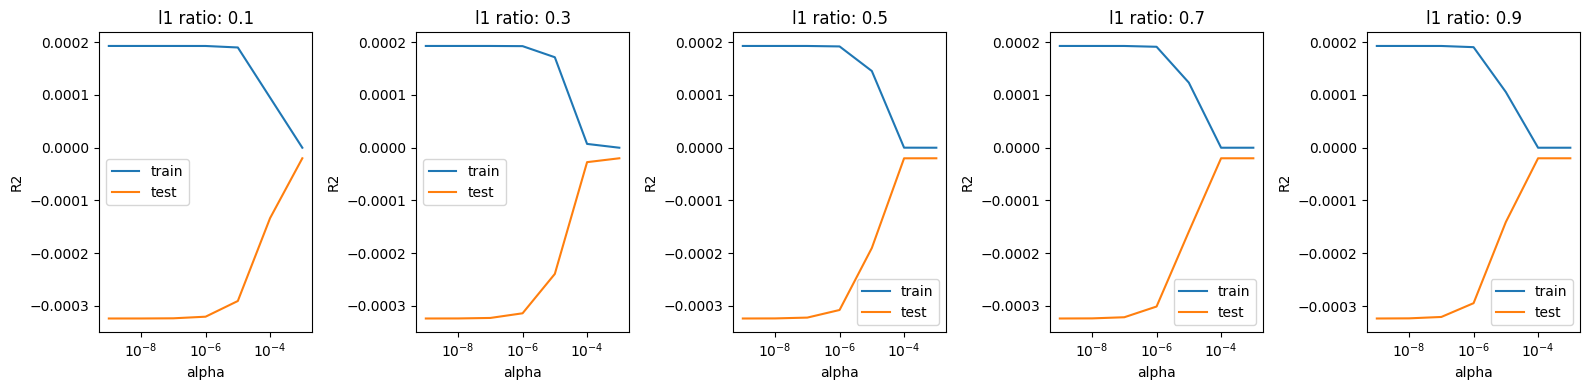

In [1329]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4), tight_layout=False)
for i, (alpha, data) in enumerate(r2_enet_df.groupby(level=1)):
    ax[i % 5].plot(data.droplevel(1)["train"], label="train")
    ax[i % 5].plot(data.droplevel(1)["test"], label="test")
    ax[i % 5].set_xscale('log')
    ax[i % 5].legend()
    ax[i % 5].set_ylabel("R2")
    ax[i % 5].set_xlabel("alpha")
    ax[i % 5].set_title(f"l1 ratio: {np.round(alpha, 1)}")
    

## Naive XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
dtrain_reg = xgb.DMatrix(X_train, y_train)

In [ ]:
params = {"objective": "reg:squarederror"}

In [ ]:
n = 100

model = xgb.train(

   params=params,

   dtrain=dtrain_reg,

   num_boost_round=n,

)

In [ ]:
print(model.eval(dtrain_reg))

## Hidden Markov Chain for Market Regimes

In [1363]:
from pathlib import Path
from scipy import stats

hmm_models = []
for file in sorted((Path.cwd().parent / "models" / "HMM").resolve().glob("*.pkl")):
    with open(file, "rb") as file: 
        hmm_model = pickle.load(file)
    hmm_models.append(hmm_model)
hmm_train = (in_sample_weights * X_in_sample["ResidReturnD-1"]).dropna().groupby(level=1).sum()
preds = []
for model in hmm_models:
    preds.append(model.predict(hmm_train))
y_pred_train = stats.mode(np.concatenate(preds).reshape(num_hmm, -1))[0].squeeze(0)
for i, date in enumerate(y_train.index.get_level_values(1).unique()):
    eval_hmm.loc[(slice(None), date), "cycle"] = y_pred_train[i]

KeyboardInterrupt: 

2010-01-04    0.000000
2010-01-05    0.001629
2010-01-06   -0.000370
2010-01-07    0.003850
2010-01-08    0.000875
                ...   
2013-12-24   -0.001958
2013-12-26    0.000050
2013-12-27   -0.002589
2013-12-30   -0.002697
2013-12-31   -0.000709
Length: 1006, dtype: float64

In [96]:
from hmmlearn import hmm

In [1079]:
train_weights.index.names = ("level_0", None)

In [169]:
hmm_train = (train_weights * X_train["ResidReturnD-1"]).dropna().groupby(level=1).sum()

In [195]:
hmm_train = ((hmm_train - hmm_train.mean()) / hmm_train.std()).to_numpy().reshape(-1, 1)

In [196]:
hmm_train

array([[-0.08084905],
       [-0.34744432],
       [-0.91095236],
       ...,
       [-0.59966678],
       [-0.26517321],
       [ 0.52528811]])

In [ ]:
class HMMProcessor(Standardizer):
    def transform(self, series):
        self._index = series.index
        normalized_data = super().transform(series)
        ts_data = [data.values for _, data in normalized_data.stack().groupby(level=0)]
        lengths = [ts.shape[0] for ts in ts_data]
        ts_concat = np.concatenate(ts_data).reshape(-1, 1)
        return ts_concat, lengths
    
    def inverse_transform(self, predictions):
        return pd.DataFrame(predictions, index=self._index, columns=["Cycle"]).unstack(0).T.droplevel(0).stack(0)
            

In [ ]:
processor = HMMProcessor().fit(X_train["ResidReturnD-1"])

In [ ]:
hmm_train, lengths_train = processor.transform(y_train)

In [223]:
num_hmm = 50

In [1333]:
for i, hmm_model in enumerate(boosted_markov):
    with open(f"HMM_{i+1}.pkl", "wb") as file: 
        pickle.dump(hmm_model, file)

In [224]:
boosted_markov = []
for _ in range(num_hmm):
    #boosted_markov.append(hmm.GaussianHMM(n_components=3).fit(hmm_train, lengths=lengths_train))
    boosted_markov.append(hmm.GaussianHMM(n_components=3).fit(hmm_train))
    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

In [225]:
preds = []
for model in boosted_markov:
    preds.append(model.predict(hmm_train))

In [221]:
y_pred_train = scipy.stats.mode(np.concatenate(preds).reshape(num_hmm, -1))[0].squeeze(0)

/var/folders/9w/vls_pj350g3b62pyz_4t5hp80000gn/T/ipykernel_96170/76586212.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred_train = scipy.stats.mode(np.concatenate(preds).reshape(num_hmm, -1))[0].squeeze(0)


In [188]:
hmmmodel_1 = hmm.GaussianHMM(n_components=3).fit(hmm_train.to_numpy().reshape(-1, 1))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [189]:
y_pred_train = hmmmodel_1.predict(hmm_train.to_numpy().reshape(-1, 1))

In [229]:
y_pred_train

(1006,)

In [266]:
daily_train_weights = train_weights.unstack(level=1)
daily_train_weights.drop(list(set(daily_train_weights.index) - (set(y_train.index.get_level_values(0)))), inplace=True)

In [267]:
daily_train_weights

2010-01-04  2010-01-05  2010-01-06  2010-01-07  \
level_0                                                                  
BBG000B9WH86              0.002124    0.002124    0.002124    0.002123   
BBG000B9WJ73              0.001971    0.001971    0.001971    0.001971   
BBG000B9X8C0                   NaN         NaN         NaN         NaN   
BBG000B9XG87                   NaN         NaN         NaN         NaN   
BBG000B9XRY4              0.002350    0.002351    0.002351    0.002352   
...                            ...         ...         ...         ...   
GEN_EQ0034828200001000    0.001941    0.001945    0.001945    0.001946   
GEN_EQ0085215200001000    0.001984    0.001984    0.001987    0.001988   
GEN_EQ0096849600001000         NaN         NaN         NaN         NaN   
GEN_EQ0117562400001000    0.001982    0.001982    0.001982    0.001982   
GEN_EQ0140919900001000    0.001943    0.001942    0.001943    0.001942   

                        2010-01-08  2010-01-11  2010-01-12  2010-01-13  \
level_0                                                                  
BBG000B9WH86              0.002124    0.002123    0.002124    0.002124   
BBG000B9WJ73              0.001972    0.001971    0.001975    0.001974   
BBG000B9X8C0                   NaN         NaN         NaN         NaN   
BBG000B9XG87                   NaN         NaN         NaN         NaN   
BBG000B9XRY4              0.002353    0.002355    0.002356    0.002356   
...                            ...         ...         ...         ...   
GEN_EQ0034828200001000    0.001946    0.001946    0.001946    0.001945   
GEN_EQ0085215200001000    0.001987    0.001987    0.001986    0.001986   
GEN_EQ0096849600001000         NaN         NaN         NaN         NaN   
GEN_EQ0117562400001000    0.001982    0.001982    0.001981    0.001981   
GEN_EQ0140919900001000    0.001942    0.001942    0.001945    0.001946   

                        2010-01-14  2010-01-15  ...  2014-12-17  2014-12-18  \
level_0                                         ...                           
BBG000B9WH86              0.002125    0.002124  ...    0.002050    0.002050   
BBG000B9WJ73              0.001971    0.001971  ...         NaN         NaN   
BBG000B9X8C0                   NaN         NaN  ...         NaN         NaN   
BBG000B9XG87                   NaN         NaN  ...         NaN         NaN   
BBG000B9XRY4              0.002357    0.002357  ...    0.002357    0.002357   
...                            ...         ...  ...         ...         ...   
GEN_EQ0034828200001000    0.001946    0.001946  ...         NaN         NaN   
GEN_EQ0085215200001000    0.001987    0.001987  ...         NaN         NaN   
GEN_EQ0096849600001000         NaN         NaN  ...         NaN         NaN   
GEN_EQ0117562400001000    0.001981    0.001983  ...         NaN         NaN   
GEN_EQ0140919900001000    0.001947    0.001946  ...         NaN         NaN   

                        2014-12-19  2014-12-22  2014-12-23  2014-12-24  \
level_0                                                                  
BBG000B9WH86              0.002049    0.002049    0.002049    0.002049   
BBG000B9WJ73                   NaN         NaN         NaN         NaN   
BBG000B9X8C0                   NaN         NaN         NaN         NaN   
BBG000B9XG87                   NaN         NaN         NaN         NaN   
BBG000B9XRY4              0.002360    0.002356    0.002356    0.002353   
...                            ...         ...         ...         ...   
GEN_EQ0034828200001000         NaN         NaN         NaN         NaN   
GEN_EQ0085215200001000         NaN         NaN         NaN         NaN   
GEN_EQ0096849600001000         NaN         NaN         NaN         NaN   
GEN_EQ0117562400001000         NaN         NaN         NaN         NaN   
GEN_EQ0140919900001000         NaN         NaN         NaN         NaN   

                        2014-12-26  2014-12-29  2014-12-30  2014-12-31  
level_0                           

In [282]:
weighted_ret = y_train.unstack().apply(lambda x: np.average(x.fillna(0), weights=daily_train_weights[x.name].fillna(0))).T
weighted_ret

2010-01-04   -0.000488
2010-01-05   -0.001771
2010-01-06    0.002554
2010-01-07    0.000122
2010-01-08    0.002118
                ...   
2013-12-24   -0.000467
2013-12-26   -0.001340
2013-12-27   -0.000214
2013-12-30    0.001220
2013-12-31   -0.000343
Length: 1006, dtype: float64

In [288]:
pd.DataFrame(y_pred_train, dtype=("category"))

0
0     2
1     0
2     2
3     0
4     2
...  ..
1001  0
1002  0
1003  0
1004  0
1005  0

[1006 rows x 1 columns]

[Text(0.5, 0, 'States'), Text(0, 0.5, '"Index" returns')]

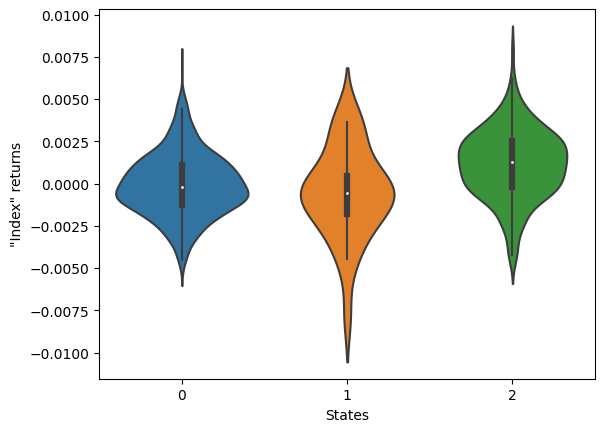

In [314]:
ax = sns.violinplot(x = y_pred_train, y=weighted_ret)
ax.set(xlabel='States', ylabel='"Index" returns')

In [292]:
y_pred_train

array([2, 0, 2, ..., 0, 0, 0])

In [294]:
eval_hmm = y_train.copy().to_frame()

In [298]:
eval_hmm["cycle"] = np.NaN

In [305]:
for i, date in enumerate(y_train.index.get_level_values(1).unique()):
    eval_hmm.loc[(slice(None), date), "cycle"] = y_pred_train[i]

In [306]:
eval_hmm

Target  cycle
level_0                                           
BBG000B9WH86           2010-01-04 -0.161663    2.0
                       2010-01-05  0.143294    0.0
                       2010-01-06 -0.102812    2.0
                       2010-01-07 -0.044104    0.0
                       2010-01-08  0.119874    2.0
...                                     ...    ...
GEN_EQ0140919900001000 2011-01-12  0.061040    2.0
                       2011-01-13  0.071008    1.0
                       2011-01-14  0.033858    2.0
                       2011-01-18 -0.000999    0.0
                       2011-01-19 -0.005147    2.0

[500629 rows x 2 columns]

<Axes: xlabel='cycle', ylabel='Target'>

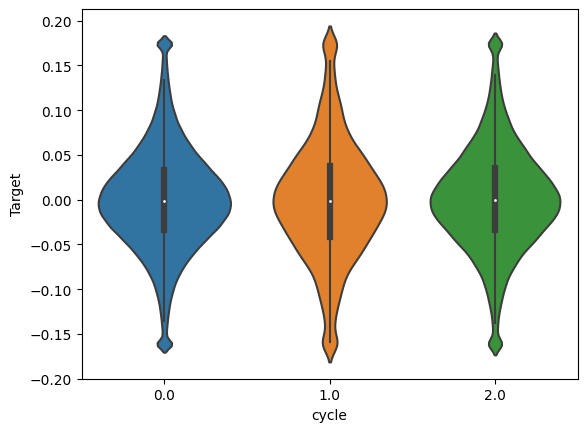

In [309]:
sns.violinplot(x=eval_hmm["cycle"], y=eval_hmm["Target"])

In [ ]:
market_cycles_per_id = processor.inverse_transform(y_pred_train).unstack(1)
market_cycles_per_id.index.name = "Id"
market_cycles_per_id

In [ ]:
vol_window = 20

In [ ]:
vol_per_id = y_train.unstack(0).rolling(vol_window).std()
vol_per_id.columns.name = "Id"
vol_per_id

In [ ]:
joint = market_cycles_per_id.stack().to_frame().merge(vol_per_id.stack().swaplevel(0,1).to_frame(), how="inner", left_index=True, right_index=True)
joint["rets"] = dataset["Target"]
joint.columns=["Cycle", "Vol", "Rets"]
joint

In [ ]:
joint["Cycle"].value_counts()

In [ ]:
sns.violinplot(x=joint["Cycle"].values, y=joint["Rets"].values)

In [ ]:
sns.violinplot(x=joint["Cycle"].values, y=joint["Vol"].values)

In [ ]:
mode_weights = market_weights.unstack(level=0).droplevel(0, axis=1)

In [ ]:
mode_weights.drop(list(set(mode_weights.index) - (set(market_cycles_per_id.index))), inplace=True)
mode_weights

In [232]:
from sklearn.utils.extmath import weighted_mode

In [ ]:
market_cycles = market_cycles_per_id.apply(lambda x: weighted_mode(x, mode_weights[x.name])[0]).T.rename(columns={0:"cycle"})

In [ ]:
market_cycles

In [ ]:
market_cycles.value_counts()

In [ ]:
smoothed_window = 20

In [ ]:
smoothed_market_cycles = market_cycles.rolling(smoothed_window).apply(lambda x: x.mode()[0]).dropna()#.reset_index().plot(kind='scatter', x="index", y=0)

In [ ]:
smoothed_market_cycles

In [ ]:
smoothed_market_cycles.value_counts()

In [ ]:
y_train.groupby(level=0).rolling(window=20).std()

In [ ]:
vol = vol_per_id.apply(lambda x: np.average(x, weights=mode_weights[x.name]), axis=1)
vol.name = "vol"

In [ ]:
vol

In [ ]:
cycle_chars = smoothed_market_cycles.merge(vol, how="left", left_index=True, right_index=True)

In [ ]:
cycle_chars

In [ ]:
mean_ret = y_train.unstack(0).fillna(0).apply(lambda x: np.average(x, weights=mode_weights[x.name].fillna(0)), axis=1)
mean_ret

In [ ]:
cycle_chars["mean_ret"] = mean_ret

In [ ]:
import seaborn as sns

In [ ]:
sns.violinplot(cycle_chars["cycle"], cycle_chars["vol"])

In [ ]:
sns.violinplot(cycle_chars["cycle"], cycle_chars["mean_ret"])

In [ ]:
sub_dataset = dataset.copy()

In [ ]:
sub_dataset

In [ ]:
usecols = [f"ResidReturnD{i}" for i in range(-1, -5, -1)] + [f"Volume{i}" for i in range(-1, -26, -1)] + ["Target"]

In [ ]:
sub_dataset = sub_dataset[usecols]

In [ ]:
sub_dataset

In [ ]:
sub_dataset["Daily_Volume"] = sub_dataset[[f"Volume{i}" for i in range(-1, -26, -1)]].sum(axis=1)
sub_dataset.drop([f"Volume{i}" for i in range(-1, -26, -1)], axis=1, inplace=True)

In [ ]:
sub_dataset["HMMCycle"] = market_cycles_per_id.stack().astype("category")

In [ ]:
sub_dataset

In [ ]:
sub_dataset.swaplevel(0,1).sort_index()

In [ ]:
sub_data_train = sub_dataset.reset_index(0).loc[:'2014-01-01'].set_index("level_0", append=True).swaplevel(0,1).dropna()


In [ ]:
sub_data_val = sub_dataset.reset_index(0).loc['2014-01-01':].set_index("level_0", append=True).swaplevel(0,1)

In [ ]:
sub_data_val

In [ ]:
sub_data_val["ResidReturnD-1"]

In [ ]:
hmm_raw_val_input = sub_data_val["ResidReturnD-1"].unstack(1)
complete_hmm_val_input = pd.DataFrame(np.nan, index=hmm_df.index, columns=hmm_raw_val_input.columns).fillna(hmm_raw_val_input)
hmm_val_input_df = pd.DataFrame(hmm_scaler.transform(complete_hmm_val_input.T), index=complete_hmm_val_input.columns, columns=complete_hmm_val_input.index).T

In [ ]:
hmm_raw_val_input

In [ ]:
hmm_val_input_df

In [ ]:
hmm_raw_val_input

In [ ]:
hmm_ts_val = [data.values for _, data in hmm_val_input_df.stack().groupby(level=0)]
lengths_val = [ts.shape[0] for ts in hmm_ts_val]
hmmdata_val = np.concatenate(hmm_ts_val).reshape(-1, 1)

In [ ]:
hmm_ts_val

In [ ]:
pd.DataFrame(hmmmodel.predict(hmmdata_val, lengths=lengths_val), index=sub_data_val.index, columns=["Cycle"]).unstack(0).T.droplevel(0)

In [ ]:
sub_X_train, sub_y_train = sub_data_train.drop("Target", axis=1), sub_data_train['Target']


In [ ]:
sub_X_val, sub_y_val = sub_data_val.drop("Target", axis=1), sub_data_val['Target']

In [ ]:
sub_X_val

In [ ]:
dsub_train_reg = xgb.DMatrix(sub_X_train, sub_y_train, enable_categorical=True)


In [ ]:
dsub_val_reg = xgb.DMatrix(sub_X_val, sub_y_val, enable_categorical=True)

In [ ]:
n = 100

sub_model = xgb.train(

   params={"objective": "reg:squarederror"},

   dtrain=dsub_train_reg,

   num_boost_round=n

)

In [ ]:
print(sub_model.eval(dsub_train_reg))

In [ ]:
sub_y_train

In [ ]:
SST_IN = ((sub_y_train - sub_y_train.unstack(0).mean()) ** 2).mean()

In [ ]:
SSR_IN = ((sub_y_train - sub_model.predict(dsub_train_reg)) ** 2).mean()


In [ ]:
1 - SSR/SST

In [ ]:
xgb.plot_importance(sub_model)

In [ ]:
sub_model.predict(dsub_val_reg)

In [ ]:
print(sub_model.eval(dsub_val_reg))

## Neural Network

In [789]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [790]:
class NNDataSet(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        _X = self.X[index]
        _y = self.y[index]
        return _X, _y

In [882]:
X_train_nn = X_train.copy().astype(float)
X_val_nn = X_val.copy().astype(float)

In [883]:
nn_columns = [("Volume" not in col) for col in X_train_nn.columns]
X_train_nn = X_train_nn.loc[:, nn_columns]
X_val_nn = X_val_nn.loc[:, nn_columns]

In [793]:
X_train_nn

ResidReturnD-20  ResidReturnD-19  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.018772        -0.073601   
                       2011-01-13        -0.073601        -0.090919   
                       2011-01-14        -0.090919         0.011597   
                       2011-01-18         0.011597        -0.074718   
                       2011-01-19        -0.074718        -0.016516   

                                   ResidReturnD-18  ResidReturnD-17  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.090919         0.011597   
                       2011-01-13         0.011597        -0.074718   
                       2011-01-14        -0.074718        -0.016516   
                       2011-01-18        -0.016516        -0.030521   
                       2011-01-19        -0.030521         0.010474   

                                   ResidReturnD-16  ResidReturnD-15  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.074718        -0.016516   
                       2011-01-13        -0.016516        -0.030521   
                       2011-01-14        -0.030521         0.010474   
                       2011-01-18         0.010474        -0.026305   
                       2011-01-19        -0.026305        -0.042175   

                                   ResidReturnD-14  ResidReturnD-13  \
level_0                                                               
BBG000B9WH86           2010-01-04         0.000000         0.000000   
                       2010-01-05         0.000000         0.000000   
                       2010-01-06         0.000000         0.000000   
                       2010-01-07         0.000000         0.000000   
                       2010-01-08         0.000000         0.000000   
...                                            ...              ...   
GEN_EQ0140919900001000 2011-01-12        -0.030521         0.010474   
                       2011-01-13         0.010474        -0.026305   
                       2011-01-14        -0.026305        -0.042175   
                       2011-01-18        -0.042175         0.006086   
                       2011-01-19         0.006086         0.025064   

                                   ResidReturnD-12  ResidReturnD-11  ...  \
level_0                                                              ...   
BBG000B9WH86           2010-01-04         0.000000         0.000000  ...   
                       2010-01-05         0.000000         0.000000  ...   
                       2010-01-06  

In [794]:
batch_size = 64

In [1119]:
train_loader = DataLoader(NNDataSet(torch.Tensor(X_train_nn.to_numpy()), torch.Tensor(y_train.to_numpy())), batch_size=batch_size)

In [884]:
X_val_nn, y_val_nn = torch.Tensor(X_val_nn.to_numpy()), torch.Tensor(y_val.to_numpy())
                            

In [797]:
train_size = y_train.shape[0]
val_size = y_val_nn.shape[0]

In [1096]:
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, x):
        return self.model(x)

In [1010]:
class DoubleLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1),
        )
        
    def forward(self, x):
        return self.model(x)

In [1015]:
learning_rate = 0.001
num_epochs = 20
input_size = X_train_nn.shape[1]
hidden_size1 = 30
hidden_size2 = 10

In [1016]:
model = DoubleLayerNN(input_size, hidden_size1, hidden_size2)

In [1017]:
criterion = nn.MSELoss(reduction='sum')

In [1018]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [1019]:
losses = {}

for epoch in range(num_epochs):
    
    losses[epoch] = {"train": 0,  "val": 0}
    
    model.train()
    
    for i, batch in enumerate(train_loader):
        
        y_preds = model(batch[0])
        
        optimizer.zero_grad()
        
        loss = criterion(y_preds.squeeze(), batch[1])
        losses[epoch]["train"] += loss.item()
        loss.backward()
        optimizer.step()
        y_preds_2 =  model(batch[0])
        
    losses[epoch]["train"] = losses[epoch]["train"] / train_size
    
    model.eval()
    
    val_y_preds = model(X_val_nn)
    val_loss = criterion(val_y_preds.squeeze(), y_val_nn)
    losses[epoch]["val"] = val_loss.item() / val_size

<Axes: >

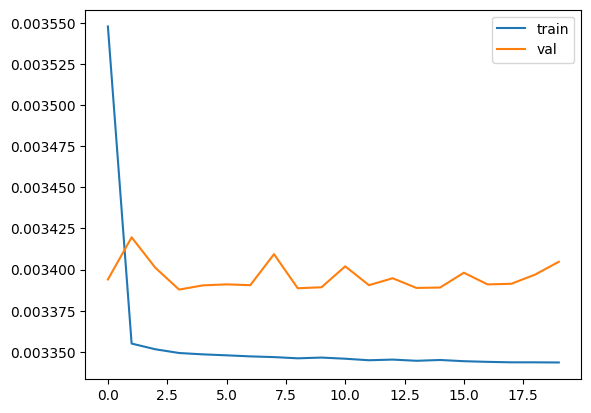

In [1020]:
pd.DataFrame.from_dict(losses, orient="index").plot()

In [1008]:
import sklearn.metrics as metrics

In [1038]:
y_preds_train = np.array(model(torch.Tensor(X_train_nn.to_numpy())).tolist())

In [1087]:
insampleR2 = metrics.r2_score(y_train, y_preds_train, sample_weight=train_weights)

In [1034]:
y_preds_val = np.array(model(torch.Tensor(X_val_nn)).tolist())

In [1088]:
outsampler2 = metrics.r2_score(y_val, y_preds_val, sample_weight=val_weights) 

In [1091]:
pd.DataFrame([insampleR2, outsampler2], index=["IS", "OOS"], columns=["R2"]).T

IS       OOS
R2 -0.001472 -0.004859

In [1125]:
hidden_sizes = [5, 10, 15, 20, 30, 50]

In [1148]:
learning_rate = 0.001
num_epochs = 15
input_size = X_train_nn.shape[1]

In [1151]:
losses = {}
r2 = {}

for hidden_size in hidden_sizes:
    model = SingleLayerNN(input_size, hidden_size)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    for epoch in range(num_epochs):

        losses[(hidden_size,epoch)] = {"train": 0,  "val": 0}
        r2[(hidden_size,epoch)] = {"train": 0,  "val": 0}
        train_preds = []
        
        model.train()

        for i, batch in enumerate(train_loader):

            y_preds = model(batch[0])
            train_preds.extend(y_preds.tolist())
            
            
            optimizer.zero_grad()

            loss = criterion(y_preds.squeeze(), batch[1])
            losses[(hidden_size,epoch)]["train"] += loss.item()
            loss.backward()
            optimizer.step()
            y_preds_2 =  model(batch[0])

        losses[(hidden_size,epoch)]["train"] = losses[(hidden_size,epoch)]["train"] / train_size
        r2[(hidden_size,epoch)]["train"] = metrics.r2_score(y_train.to_numpy(), np.array(train_preds), sample_weight=train_weights)

        model.eval()

        val_y_preds = model(X_val_nn)
        
        r2[(hidden_size,epoch)]["val"] = metrics.r2_score(np.array(y_val_nn.tolist()), np.array(val_y_preds.tolist()), sample_weight=val_weights)
        
        val_loss = criterion(val_y_preds.squeeze(), y_val_nn)
        losses[(hidden_size,epoch)]["val"] = val_loss.item() / val_size
        

In [1152]:
nn_res = pd.DataFrame.from_dict(r2, orient="index").merge(pd.DataFrame.from_dict(losses, orient="index"), left_index=True, right_index=True, suffixes=["_r2","_loss"])

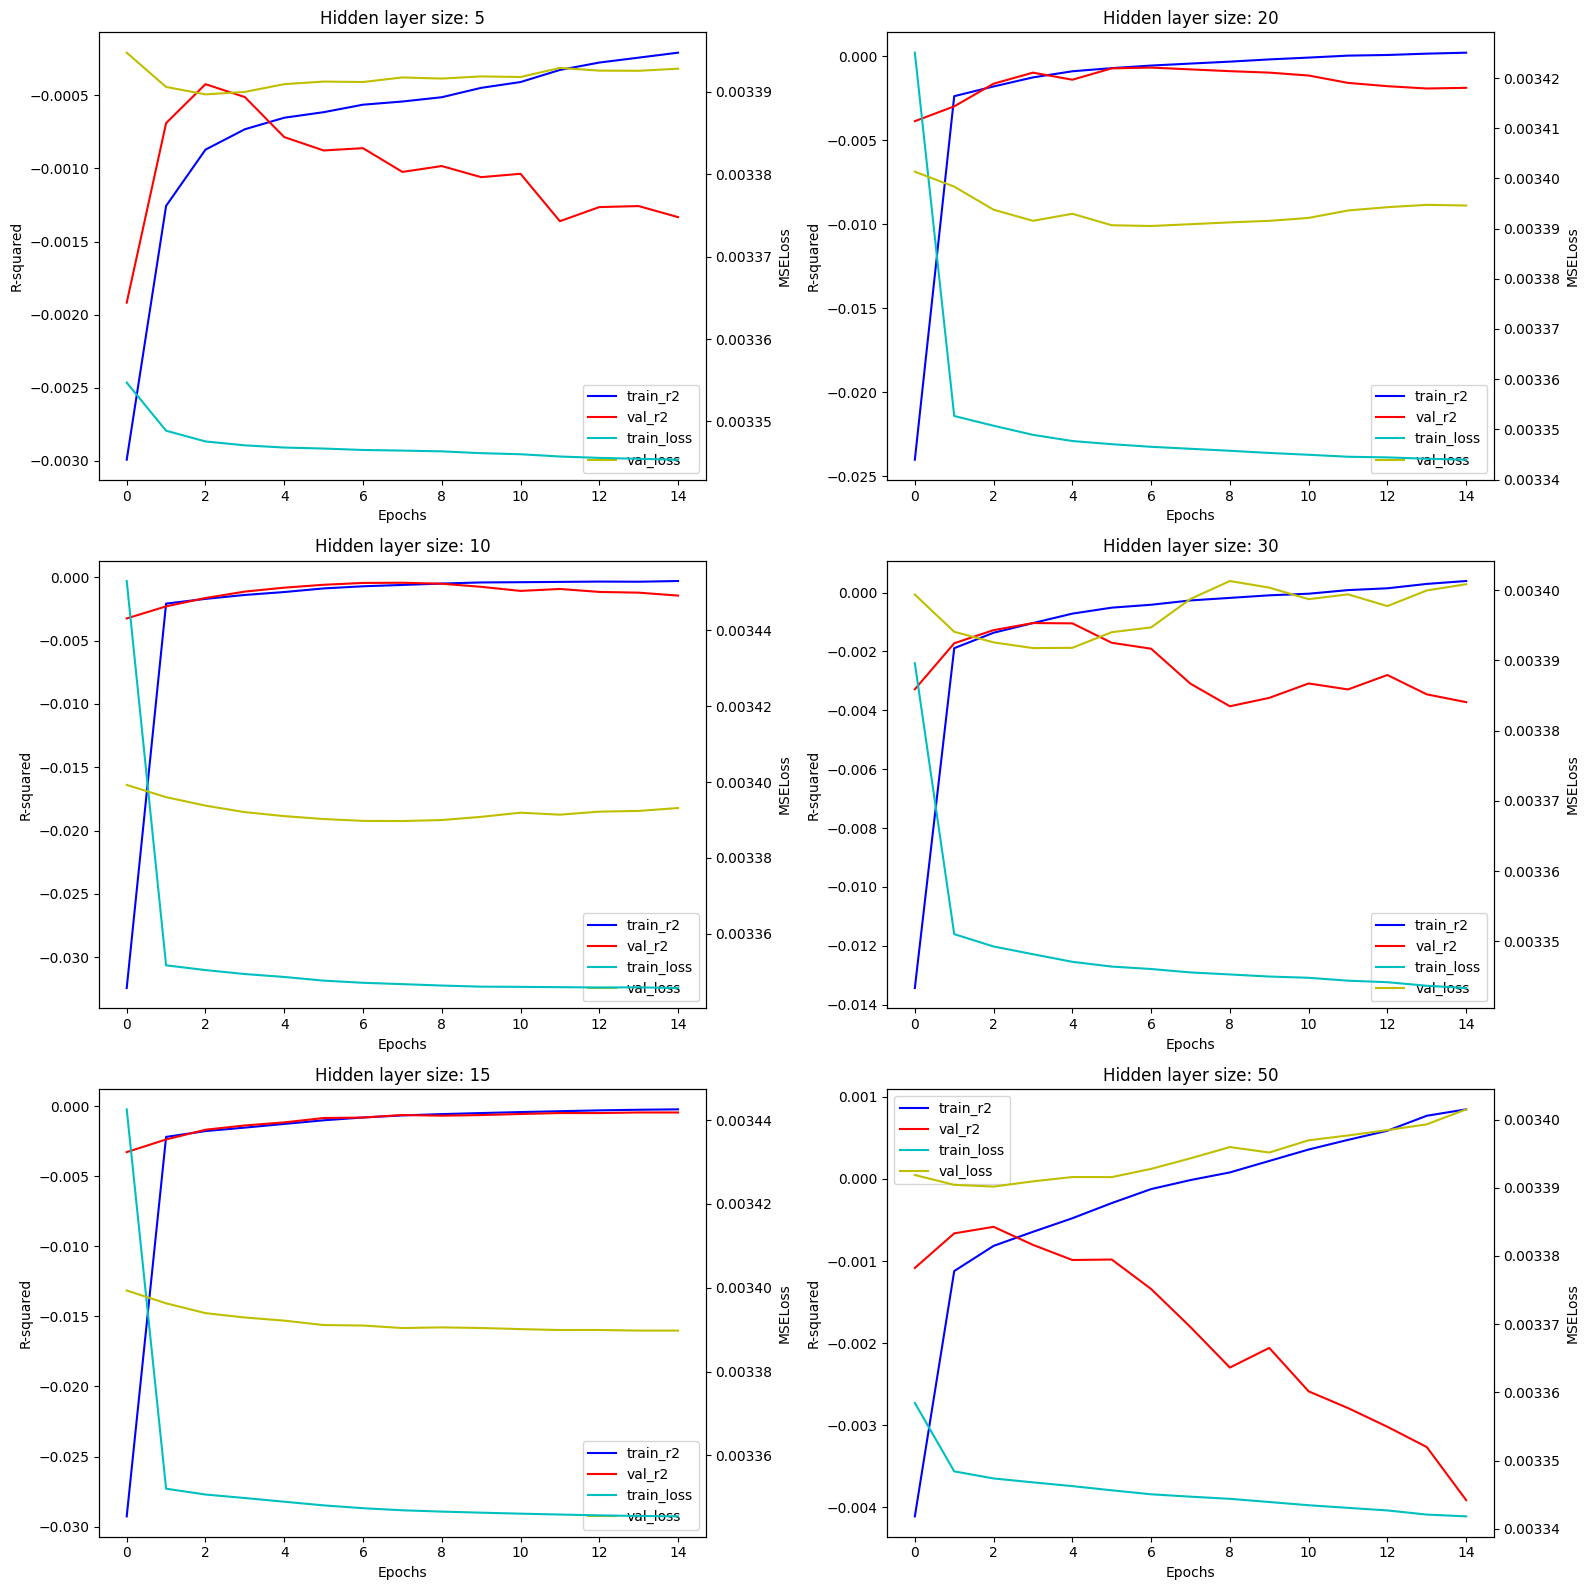

In [1155]:
fig, ax = plt.subplots(3, 2, figsize=(16, 16), tight_layout=False)
ax2 = []
for i, (num_hidden, data) in enumerate(nn_res.groupby(level=0)):
    l1 = ax[i % 3][i // 3].plot(data.droplevel(0)["train_r2"], label="train_r2", color='b')
    l2 = ax[i % 3][i // 3].plot(data.droplevel(0)["val_r2"], label="val_r2", color='r')
    ax[i % 3][i // 3].set_title(f"Hidden layer size: {num_hidden}")
    ax2.append(ax[i % 3][i // 3].twinx())
    l3 = ax2[-1].plot(data.droplevel(0)["train_loss"], label="train_loss", color='c')
    l4 = ax2[-1].plot(data.droplevel(0)["val_loss"], label="val_loss", color='y')
    lns = l1+l2+l3+l4
    labs = [l.get_label() for l in lns]
    ax[i % 3][i // 3].legend(lns, labs, loc=0)
    ax[i % 3][i // 3].set_ylabel("R-squared")
    ax2[-1].set_ylabel("MSELoss")
    ax[i % 3][i // 3].set_xlabel("Epochs")
    